### **Load Dependencies**

In [1]:
from __future__ import annotations

import operator, warnings
from pydantic import BaseModel, Field
from typing import TypedDict, List, Annotated, Literal, Optional
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_tavily import TavilySearch

from IPython.display import Markdown, display, Image
from dotenv import load_dotenv
from pathlib import Path

from prompt import *

warnings.filterwarnings("ignore")

load_dotenv()

/home/muhammadumerkhan/Gen-Agentic-AI-Tutorials/.venv/lib/python3.12/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
/home/muhammadumerkhan/Gen-Agentic-AI-Tutorials/.venv/lib/python3.12/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


True

- **Test LLM Model**

In [2]:
llm = ChatOpenAI(model="gpt-4.1-mini")
llm.invoke("hello").content

'Hello! How can I assist you today?'

#### **Define Schemas**

##### **Task**
- **ID:** Task ID
- **Title:** Title of the task
- **Goal:** One sentence describing what the reader should be able to do/understand after this section.
- **Bullets:** 3–5 concrete, non-overlapping subpoints to cover in this section.
- **Target Words:** Target word count for this section (120–450).
- **Tags:** List of tags

In [3]:
class Task(BaseModel):
    id: int = Field(..., description="ID of the task")
    title: str = Field(..., description="Title of the task")
    
    goal: str = Field(
        ..., 
        description="One sentence describing what the reader should be able to do/understand after this section."
    )

    bullets: List[str] = Field(
        ..., min_length=3, max_length=5,
        description="3–5 concrete, non-overlapping subpoints to cover in this section."
    )

    target_words: int  = Field(
        ...,
        description="Target word count for this section (120–450)."
    )

    tags: List[str] = Field(default_factory=list)
    requires_research: bool = False
    requires_citations: bool = False
    requires_code: bool = False

##### **Plan**
- **Blog Title:** Title of the blog post
- **Audience:** Who the blog is for.
- **Tone:** Writing tone of the blog (e.g., practical, crisp).
- **Blog Kind:** What kind of blog is this?
- **Constraints:** List of constraints
- **Tasks:** List of tasks

In [4]:
class Plan(BaseModel):
    blog_title: str = Field(..., description="Title of the blog")
    audience: str = Field(..., description="Who the blog is for.")
    tone: str = Field(..., description="Writing tone of the blog (e.g., practical, crisp).")
    blog_kind: Literal["explainer", "tutorial", "news_roundup", "comparison", "system_design"] = "explainer"
    constraints: List[str] = Field(default_factory=list)
    tasks: List[Task] = Field(..., description="List of tasks", min_length=5, max_length=7)

##### **Evidence Item**
- **Title:** Title of the evidence item
- **URL:** URL of the evidence item
- **Published At:** Published date of the evidence item
- **Snippet:** Summary of the evidence item
- **Source:** Source of the evidence item

In [5]:
class EvidenceItem(BaseModel):
    title: str = Field(..., description="Title of the evidence item")
    url: str = Field(..., description="URL of the evidence item")
    snippet: Optional[str] = Field(
        ..., 
        description="Snippet of the evidence item"
    )

##### **Route Decision**
- **Need Research:** Whether the task requires research
- **Mode:** Mode of the task (open_book, hybrid, closed_book)
- **Queries:** List of queries

In [6]:
class RouteDecision(BaseModel):
    need_research: bool = Field(
        ..., 
        description="Whether the blog needs research (True/False)."
    )
    
    mode: Literal["open_book", "hybrid", "closed_book"] = Field(
        ..., 
        description="Mode of the blog (open_book/hybrid/closed_book)."
    )
    
    queries: List[str] = Field(
        ..., 
        description="Queries for the blog.",
        default_factory=list
    )

##### **Evidence Pack**
- **Evidence:** List of evidence items

In [7]:
class EvidencePack(BaseModel):
    evidence: List[EvidenceItem] = Field(
        description="List of evidence items",
        default_factory=list
    )

#### **Define State Model**
- Shared memory

In [8]:
class State(TypedDict):
    topic: str                                          # topic of the blog

    # routing / research
    mode: str                                           # mode of the blog
    need_research: bool                                 # whether the blog needs research
    queries: List[str]                                  # queries for the blog

    # evidence
    evidence: List[EvidencePack]                        # evidence for the blog
    plan: Optional[Plan]                                # plan for the blog

    # workers
    sections: Annotated[List[str], operator.add]        # reducer: results from workers get concatenated automatically
    final: str                                          # final blog post

## **Nodes**

- **Router:** Given a topic, decide whether the blog needs research or not

In [9]:
def router_node(state: State) -> dict:

    """
    Router node for the blog agent.
        - Given a topic, decide whether the blog needs research or not.
        - If the blog needs research, decide the mode of the blog and the queries for the blog.
    """

    topic = state['topic']
    decider = llm.with_structured_output(RouteDecision).invoke([
        SystemMessage(content=ROUTER_SYSTEM_PROMPT),
        HumanMessage(content=f"Topic: {topic}")
    ])

    return { 
        "need_research": decider.need_research,
        "mode": decider.mode,
        "queries": decider.queries
    }

In [10]:
decisions = router_node({
    "topic": "Machine Learning"
})

In [11]:
decisions

{'need_research': True,
 'mode': 'hybrid',
 'queries': ['latest advancements in machine learning algorithms 2024',
  'top machine learning frameworks and tools in 2024',
  'case studies of successful machine learning implementation in industry 2024',
  'machine learning model interpretability techniques 2024',
  'impact of recent hardware improvements on machine learning training 2024']}

##### **Route Next:** Given a state, decide whether to route to the research node or the orchestrator node

In [12]:
def route_next(state: State) -> str:
    """
    Router function for the blog agent.
        - Given a topic, decide whether the blog needs research or not.
        - If the blog needs research, decide the mode of the blog and the queries for the blog.
    """
    return "research" if state["need_research"] else "orchestrate"

##### **Tavily Search:** Given a query, search for evidence
- **Query:** Query to search for evidence.
- **Max Results:** Maximum number of results to return.

In [13]:
def _tavily_search(query: str, max_results: int = 5) -> List[dict]:

    search = TavilySearch(max_results=max_results)
    results = search.invoke({ "query": query })

    normalized: List[dict] = []
    for r in results['results'] or []:
        normalized.append({
            "title": r.get("title") or "",
            "url": r.get("url") or "",
            "snippet": r.get("content") or r.get("snippet") or "",
        })
    return normalized

In [14]:
test_tavily_search = _tavily_search("latest machine learning algorithms 2024")

In [15]:
test_tavily_search[0]['snippet']

'Summary: This blog highlights ten crucial Machine Learning algorithms to know in 2024, including linear regression, decision trees,'

In [16]:
def research_node(state: State) -> dict:
    """
    Research node for the blog agent.
        - Given queries, search for evidence.
        - Extract evidence from the search results.
        - Return evidence.
    """

    queries = state.get("queries", [])
    max_results = 6

    raw_results: List[dict] = []

    for q in queries:
        raw_results.extend(_tavily_search(q, max_results))

    if not raw_results:
        return { "evidence": [] }

    extractor = llm.with_structured_output(EvidencePack).invoke([
        SystemMessage(content=RESEARCH_SYSTEM_PROMPT),
        HumanMessage(content=f"Raw Results: \n{raw_results}")
    ])

    # Deduplicate by URL
    dedup = {}
    for e in extractor.evidence:
        if e.url:
            dedup[e.url] = e

    return { "evidence": list(dedup.values()) }

In [17]:
decisions['queries'][:3]

['latest advancements in machine learning algorithms 2024',
 'top machine learning frameworks and tools in 2024',
 'case studies of successful machine learning implementation in industry 2024']

In [18]:
query_results = research_node({
    "queries": decisions['queries'][:3]
})

In [19]:
query_results['evidence'][0].title

'AI and Machine Learning Trends in 2024 - Dataversity'

In [20]:
len([e.model_dump() for e in query_results['evidence']])

17

- **Orchestrator:** Given a topic, generate 5-7 sections on the topic.

In [21]:
def orchestrator(state: State) -> dict:
    """ 
    Orchestrator function for the blog agent.
        - Given a topic, mode, and evidence, generate a blog plan.
        - Generate:
            - blog title
            - audience
            - tone
            - tasks
    """

    planner = llm.with_structured_output(Plan)

    evidence = state.get("evidence", [])
    mode = state.get("mode", "closed_book")

    plan = planner.invoke([
        SystemMessage(content=ORCH_SYSTEM_PROMPT),
        HumanMessage(content=(
            f"Topic: {state['topic']}\n"
            f"Mode: {mode}\n\n"
            f"Evidence (ONLY use for fresh claims; may be empty):\n"
            f"{[e.model_dump() for e in evidence][:16]}"
        )
    )])

    return { "plan":plan }

In [25]:
# query_results['evidence']

In [27]:
plans = orchestrator({
    "topic": "Machine Learning",
    "mode": decisions['mode'],
    "evidence": query_results['evidence'] or [],
})

In [44]:
# plans['plan'].tasks[0]

In [35]:
for task in plans["plan"].tasks:
    bullets_md = "\n".join(f"  - {b}" for b in task.bullets)
    
    display(Markdown(f"""
#### **{task.title}**

**Goal:** {task.goal}

**Bullets:**
{bullets_md}

**Target Words:** {task.target_words}  \n
**Tags:** {task.tags or 'None'} \n
**Requires Research:** {task.requires_research} \n
**Requires Citations:** {task.requires_citations}   \n

---
"""))


#### **Overview of Machine Learning Trends in 2024**

**Goal:** Provide a high-level summary of the key machine learning trends shaping development in 2024.

**Bullets:**
  - Identify the shift towards cloud-based ML and edge AI deployments as dominant trends.
  - Summarize the increased focus on data-centric frameworks and reduced data dependency techniques.
  - Mention advancements in NLP algorithms improving machine comprehension accuracy.
  - Highlight the rise of meta-learning, prompt engineering, and self-supervised approaches.
  - Explain the growing importance of AI ethics and governance in ML workflows.

**Target Words:** 400  

**Tags:** ['trends', 'overview', '2024'] 

**Requires Research:** True 

**Requires Citations:** True   


---



#### **Emerging Machine Learning Algorithms and Techniques**

**Goal:** Detail the new and evolving algorithms and methodologies gaining traction in 2024 ML projects.

**Bullets:**
  - Describe Generative Adversarial Networks (GANs) and their use in image generation and data augmentation.
  - Outline meta-learning and its utility in reducing training data requirements and increasing adaptability.
  - Discuss self-supervised learning's role in leveraging unlabeled data efficiently.
  - Summarize advancements in automated machine learning (AutoML) and its impact on model development workload.
  - Mention practical applications of prompt engineering and model fine-tuning in real-world scenarios.

**Target Words:** 450  

**Tags:** ['algorithms', 'techniques', '2024'] 

**Requires Research:** True 

**Requires Citations:** True   


---



#### **Top Machine Learning Frameworks and Tools for Developers in 2024**

**Goal:** Help developers understand the leading ML frameworks and libraries relevant for 2024 development projects.

**Bullets:**
  - List prominent frameworks such as TensorFlow, PyTorch, Keras, and Scikit-learn and their distinctive features.
  - Discuss PyTorch’s popularity among researchers and its TorchServe model deployment capabilities.
  - Outline TensorFlow’s integration with Keras and support for diverse model types including vision and text.
  - Explain lightweight and specialized tools gaining traction, including OpenCV for computer vision.
  - Provide insights into tool selection criteria considering efficiency, community, and support.

**Target Words:** 440  

**Tags:** ['tools', 'frameworks', '2024', 'developer'] 

**Requires Research:** True 

**Requires Citations:** True   


---



#### **Industry Applications: Case Studies of Successful ML Implementations**

**Goal:** Illustrate how leading industries are applying machine learning with tangible business value in 2024.

**Bullets:**
  - Summarize JPMorgan Chase’s use of ML for risk management and fraud detection.
  - Detail Amazon’s personalization strategies and inventory optimization using ML.
  - Describe Siemens’ predictive maintenance and equipment failure prediction initiatives.
  - Include manufacturing-specific cases of ML improving quality control, energy efficiency, and process optimization.
  - Highlight warehouse automation successes driven by machine learning deployments.

**Target Words:** 430  

**Tags:** ['industry', 'case studies', 'applications'] 

**Requires Research:** True 

**Requires Citations:** True   


---



#### **Challenges and Considerations in Modern Machine Learning Deployments**

**Goal:** Discuss common hurdles, security considerations, and best practices for deploying ML in 2024.

**Bullets:**
  - Examine data privacy and ethics issues mandatory for compliant ML solutions.
  - Explore challenges in federated learning environments, including data heterogeneity.
  - Address debugging and observability techniques critical for production ML models.
  - Highlight performance and cost implications of cloud versus edge AI deployment.
  - Discuss handling edge cases and failure modes for robust model operation under real-world conditions.

**Target Words:** 420  

**Tags:** ['challenges', 'security', 'performance', 'debugging'] 

**Requires Research:** True 

**Requires Citations:** True   


---


- **Worker:** Given a task, generate a blog section

In [55]:
# Plan(**plans['plan'].model_dump())

In [43]:
# Task(**plans['plan'].tasks[0].model_dump())

In [60]:
# EvidenceItem(**query_results['evidence'][0].model_dump())

In [ ]:
def worker(payload: dict) -> dict:
    """
    Worker function for the blog agent.
        - Given a task, generate a blog section.
    """
    
    # payload contains what we sent
    task = Task(**payload["task"])
    plan = Plan(**payload["plan"])
    topic = payload["topic"]
    mode = payload.get("mode", "closed_book")
    evidence = [EvidenceItem(**e) for e in payload.get("evidence", [])]

    blog_title = plan.blog_title
    bullet_text = "\n- " + "\n- ".join(task.bullets)

    evidence_text = ""
    if evidence:
        evidence_text = "\n".join(
            f"- {e.title} | {e.url}".strip() for e in evidence[:20]
        )

    section_md = llm.invoke([
        SystemMessage(content=WORKER_SYSTEM_PROMPT),
        HumanMessage(content=(
            f"Blog Title: {blog_title}\n"
            f"Audience: {plan.audience}\n"
            f"Tone: {plan.tone}\n\n"
            f"Blog Kind: {plan.blog_kind}\n"
            f"Constraints: {plan.constraints}\n"
            f"Topic: {topic}\n\n"
            f"Mode: {mode}\n"
            f"Section Title: {task.title}\n"
            f"Goal: {task.goal}\n\n"
            f"Target Words: {task.target_words}\n\n"
            f"Tags: {", ".join(task.tags or [])}\n\n"
            f"requires_research: {"Yes" if task.requires_research else "No"}\n\n"
            f"requires_citations: {"Yes" if task.requires_research else "No"}\n\n"
            f"requires_code: {"Yes" if task.requires_research else "No"}\n\n"
            f"Evidence: {evidence_text}\n\n"
            f"Bullet: {bullet_text}\n\n"
            f"Evidence (ONLY use these URLs when citing):\n{evidence_text}\n"
        ))
    ]).content.strip()

    return { "sections": [(task.id, section_md)] }

In [64]:
section = worker({
    "task": plans['plan'].tasks[0].model_dump(),
    "plan": plans["plan"].model_dump(),
    "topic": "Machine Learning",
    "mode": decisions['mode'],
    "evidence": [e.model_dump() for e in query_results['evidence']],
})

In [71]:
_, md = section['sections'][0]

In [72]:
Markdown(md)

## Overview of Machine Learning Trends in 2024

In 2024, machine learning (ML) development is markedly influenced by the increasing shift towards **cloud-based ML and edge AI deployments**. Cloud platforms provide scalable infrastructure, enabling rapid model training and deployment with reduced latency. Concurrently, edge AI is gaining traction for real-time inference on-device, essential for applications requiring low-latency responses, such as autonomous systems and IoT devices. This hybrid approach balances computational costs with performance needs, reflecting the industry's pivot towards distributed ML architectures ([Dataversity](https://www.dataversity.net/articles/ai-and-machine-learning-trends-in-2024/), [Encord](https://encord.com/blog/machine-learning-trends-statistics/)).

A key focus this year centers on **data-centric AI frameworks** which prioritize improving data quality, annotation, and augmentation over solely scaling models. This shift emerges from the realization that many ML success stories rely heavily on optimized datasets rather than bigger models. Techniques reducing dependency on massive labeled datasets are also advancing, with innovations like semi-supervised learning and synthetic data generation lowering barriers to entry and accelerating development cycles ([Capicua](https://www.capicua.com/blog/machine-learning), [Kaggle](https://www.kaggle.com/general/543653)).

Natural Language Processing (NLP) algorithms are undergoing significant improvements in 2024, pushing the boundaries of **machine comprehension accuracy**. Transformer-based architectures now incorporate more efficient fine-tuning methods and enhanced embeddings, delivering better context understanding and reasoning capabilities. These advancements enable more nuanced semantic search, summarization, and conversational AI systems that are closer to human-like language understanding ([LinkedIn](https://www.linkedin.com/pulse/top-emerging-trends-machine-learning-2024-nick-gupta-uaasc), [DEV Community](https://dev.to/mankavelda/10-machine-learning-algorithms-to-know-in-2024-1p8j)).

Emerging learning paradigms such as **meta-learning, prompt engineering, and self-supervised learning** are shaping innovative workflows. Meta-learning techniques facilitate rapid adaptation of models to new tasks with limited data. Prompt engineering has become critical for optimizing large language models’ outputs without retraining. Self-supervised approaches exploit unlabeled data to learn feature representations effectively, making models less reliant on costly annotations ([Kaggle](https://www.kaggle.com/general/543653), [Medium](https://medium.com/@nemagan/top-machine-learning-frameworks-and-libraries-in-2024-5474cb10e039)).

Lastly, the role of **AI ethics and governance** is increasingly vital in ML workflows. With growing regulatory scrutiny and public awareness, organizations are embedding fairness, transparency, and privacy-preserving mechanisms throughout the ML lifecycle. Tooling for bias detection, explainability, and compliance tracking is becoming mainstream, enabling responsible AI deployment that aligns with ethical standards and legal requirements ([Dataversity](https://www.dataversity.net/articles/ai-and-machine-learning-trends-in-2024/), [Aalpha](https://www.aalpha.net/articles/top-artificial-intelligence-frameworks-tools/)).

```python
# Example: Self-supervised learning using contrastive loss (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, x1, x2, label):
        distance = F.pairwise_distance(x1, x2)
        loss = torch.mean(
            label * torch.pow(distance, 2) +
            (1 - label) * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2)
        )
        return loss

# Usage: optimize embeddings to bring positive pairs closer and push negatives away
```

By integrating these trends, developers can build more efficient, robust, and ethical ML solutions aligned with 2024’s evolving landscape.

- **Fanout:** Distribute tasks to workers

In [73]:
def fanout(state: State):
    return [
        Send(
            "worker", 
            { 
                "task": task.model_dump(), 
                "topic": state["topic"],
                "mode": state["mode"], 
                "plan": state["plan"].model_dump(),
                "evidence": [e.model_dump() for e in state['evidence']],
            })
        for task in state["plan"].tasks
    ]

- **Reducer:** Given a list of blog sections, generate a final blog post, and save it to a file

In [74]:
def reducer(state: State) -> dict:
    """ 
    Reducer function for the blog agent.
        - Given a list of blog sections, generate a final blog post.
        - The final blog post is saved to a file.
    """
    
    output_path = Path.cwd() / "outputs"
    output_path.mkdir(exist_ok=True)
    
    plan = state["plan"]

    ordered_sections = [md for _, md in sorted(state["sections"], key=lambda x: x[0])]
    body = "\n\n".join(ordered_sections).strip()
    final_md = f"# {plan.blog_title}\n\n{body}\n"

    # Save the final blog post
    filename = f"{plan.blog_title}.md"
    output_path = Path.cwd() / "outputs" / filename
    output_path.write_text(final_md, encoding="utf-8")

    return { "final": final_md }

- **Graph Building**

In [75]:
# Build graph
graph = StateGraph(State)

# Add nodes
graph.add_node("router", router_node)
graph.add_node("researcher", research_node)
graph.add_node("orchestrator", orchestrator)
graph.add_node("worker", worker)
graph.add_node("reducer", reducer)

# Add edges
graph.add_edge(START, "router")
graph.add_conditional_edges("router", route_next, { "research" : "researcher", "orchestrate": "orchestrator" })
graph.add_edge("researcher", "orchestrator")
graph.add_conditional_edges("orchestrator", fanout, ["worker"])
graph.add_edge("worker", "reducer")
graph.add_edge("reducer", END)

# Compile graph
blog = graph.compile()

- **Graph Workflow**

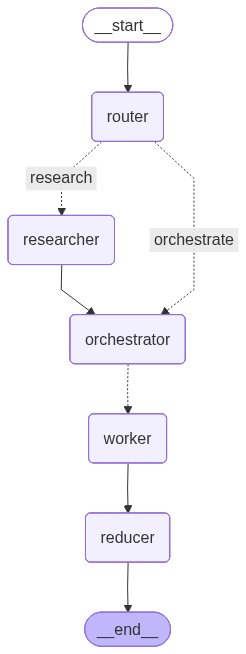

In [76]:
display(Image(blog.get_graph(xray=True).draw_mermaid_png()))

##### **Run function**

In [77]:
def run(topic: str) -> dict:
    """ 
    Run the blog agent.
        - Given a topic, generate a blog post.
        - The blog post is saved to a file.
    """
    
    output = blog.invoke({
        "topic": topic,
        "mode": "",
        "need_research": False,
        "queries": [],
        "evidence": [],
        "plan": None,
        "sections": [],
        "final": "",
    })

    return output

In [78]:
# opensource_llms = run("Write a blog on Open Source LLMs in 2026")
multimodal_llms = run("State of Multimodal LLMs in 2026")

In [83]:
display(Markdown(multimodal_llms['final']))

# State of Multimodal LLMs in 2026

## Overview of Multimodal LLMs in 2026

Multimodal large language models (LLMs) in 2026 represent a significant evolution beyond traditional text-only models. These models integrate multiple data modalities—text, images, audio, and video—enabling comprehensive understanding and generation across diverse input types. This multimodality equips them to perform vision-language reasoning, audio transcription with contextual analysis, and even video summarization, bridging gaps between different sensory data sources ([Analytics Vidhhya](https://www.analyticsvidhya.com/blog/2025/03/top-multimodal-llms/), [Ruh.ai](https://www.ruh.ai/blogs/multimodal-ai-complete-guide-2026)).

Among the current leaders, GLM-4.5V, Qwen2.5-VL-32B-Instruct, and Falcon 2 are recognized top performers. GLM-4.5V excels in high-fidelity visual question answering and image captioning tasks. Qwen2.5-VL-32B-Instruct integrates large-scale instruction tuning with expansive visual understanding, providing interactive multimodal dialogue capabilities. Falcon 2 offers efficient scaling and fine-grained multimodal alignment, effectively managing diverse input forms ([Analytics Vidhya](https://www.analyticsvidhya.com/blog/2025/03/top-multimodal-llms/), [TechTarget](https://www.techtarget.com/whatis/feature/12-of-the-best-large-language-models)).

General capabilities of these models include reasoning across modalities by correlating textual context with visual or audio inputs, enabling tasks such as cross-modal retrieval, multimodal summarization, and grounded generation. They also support diverse inputs simultaneously, facilitating applications ranging from interactive chatbots that understand images and speech to assistive systems for content creation and accessibility ([Clarifai Industry Guide](https://www.clarifai.com/blog/llms-and-ai-trends), [Hatchworks](https://hatchworks.com/blog/gen-ai/large-language-models-guide/)).

The rapid advances in multimodal LLMs are driven by two key factors: the expansion of large, high-quality multimodal datasets and architectural innovations. Enlarged datasets now encompass paired image-text, audio-transcript, and video-caption collections that improve cross-modal alignment. At the same time, novel transformer architectures and training paradigms, including vision-language fusion layers and modality-specific adapters, enhance the models’ ability to integrate and reason across heterogeneous data ([AIMultiple](https://research.aimultiple.com/large-multimodal-models/), [SiliconFlow](https://www.siliconflow.com/articles/en/best-open-source-multimodal-models-2025)).

Complementing proprietary systems, emerging open-source multimodal models have significantly improved accessibility for developers. Projects such as OpenFlamingo and LLaVA variants offer customizable, community-driven multimodal tools, lowering the barrier for research and application development. These open models emphasize modular design, enabling fine-tuning or extension over specialized data, thus fostering innovation in practical use cases from healthcare diagnostics to multimedia content generation ([SiliconFlow](https://www.siliconflow.com/articles/en/fastest-open-source-multimodal-models), [Ruh.ai](https://www.ruh.ai/blogs/multimodal-ai-complete-guide-2026)).

```python
# Example: basic inference with a multimodal model (pseudo-code)
model = load_multimodal_model("GLM-4.5V")
text_input = "Describe the scene in this image."
image_input = load_image("sample_photo.jpg")
output = model.infer(text=[text_input], images=[image_input])
print(output)
```

In summary, multimodal LLMs in 2026 combine advanced architectures and large-scale multimodal data, enabling nuanced understanding across text, vision, audio, and video. Top models achieve state-of-the-art performance in integrated reasoning tasks, while open-source alternatives expand developer access and customization opportunities. This landscape continues to drive innovation across industries relying on rich, multimodal AI capabilities.

## Major Model Architectures and Innovations in 2026

Modern multimodal LLM architectures in 2026 blend transformer backbones with specialized modality encoders and fusion layers to handle diverse inputs such as text, images, video, and audio. Typically, modality-specific encoders extract high-level features (e.g., convolutional layers for images or waveform encoders for audio), which are then mapped into a unified embedding space. These embeddings feed into a shared transformer core equipped with fusion layers designed to learn cross-modal interactions effectively. This modular design enables scalable and flexible integration across modalities while maintaining strong contextual understanding ([Analytics Vidhhya](https://www.analyticsvidhya.com/blog/2025/03/top-multimodal-llms/), [SiliconFlow](https://www.siliconflow.com/articles/en/best-open-source-multimodal-models-2025)).

A notable trend gaining traction is the use of multimodal chains and agent-based architectures. These systems combine modular input processing with integrated reasoning components, enabling sequential and conditional handling of multimodal inputs. Agents can dynamically select which modalities to attend to and how to fuse information, resulting in more interpretable and flexible pipelines that adapt reasoning strategies depending on task demands ([Ruh AI](https://www.ruh.ai/blogs/multimodal-ai-complete-guide-2026)).

Parameter scaling remains pivotal in enhancing multimodal model capability, with state-of-the-art designs reaching hundreds of billions of parameters. However, efficiency is prioritized through advanced fine-tuning techniques such as adapter modules, low-rank adaptation (LoRA), and prompt tuning. These approaches reduce update footprint and resource consumption while achieving task-specific specialization ([Clarifai Industry Guide](https://www.clarifai.com/blog/llms-and-ai-trends), [Medium](https://medium.com/@bergamo.gustavo/a-net-developers-guide-to-choosing-the-right-llm-architecture-in-2026-9ccf2f7bf65b)).

Innovations in dynamic modality attention mechanisms have greatly improved generalization by enabling the model to weigh and attend to modalities selectively based on input context. This reduces noise from irrelevant modalities and strengthens cross-modal transfer learning, where knowledge learned in one modality boosts performance in others. Such transfer enables efficient adaptation in low-data regimes and enhances robustness across diverse tasks ([SiliconFlow](https://www.siliconflow.com/articles/en/fastest-open-source-multimodal-models)).

Recent architecture-focused evaluations highlight trade-offs in deploying large multimodal models locally versus in the cloud. Local deployment favors privacy and lower latency, especially with emerging lightweight architectures and pruning. Cloud-based solutions still dominate when requiring massive compute resources for large-scale training and real-time multimodal inference pipelines ([.NET Guide](https://medium.com/@bergamo.gustavo/a-net-developers-guide-to-choosing-the-right-llm-architecture-in-2026-9ccf2f7bf65b), [AIMultiple](https://research.aimultiple.com/large-multimodal-models/)).

```python
# Example: Modular multimodal fusion layer in PyTorch-like pseudocode
class FusionLayer(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.cross_modal_attention = nn.MultiheadAttention(hidden_size, num_heads=8)
        self.norm = nn.LayerNorm(hidden_size)

    def forward(self, text_embeds, image_embeds):
        # Concatenate sequences for cross-modal attention
        combined = torch.cat([text_embeds, image_embeds], dim=0)
        attn_output, _ = self.cross_modal_attention(combined, combined, combined)
        return self.norm(attn_output)
```

This layered, attentive fusion approach serves as a foundation for many top multimodal models powering diverse applications in 2026.

---

Sources:  
[Analytics Vidhya](https://www.analyticsvidhya.com/blog/2025/03/top-multimodal-llms/)  
[SiliconFlow](https://www.siliconflow.com/articles/en/best-open-source-multimodal-models-2025)  
[Ruh AI](https://www.ruh.ai/blogs/multimodal-ai-complete-guide-2026)  
[Clarifai Industry Guide](https://www.clarifai.com/blog/llms-and-ai-trends)  
[Medium .NET Guide](https://medium.com/@bergamo.gustavo/a-net-developers-guide-to-choosing-the-right-llm-architecture-in-2026-9ccf2f7bf65b)  
[AIMultiple](https://research.aimultiple.com/large-multimodal-models/)

## Performance Benchmarks and Evaluation Techniques

Multimodal large language models (LLMs) in 2026 are rigorously evaluated using a combination of benchmark datasets and diverse task-specific metrics to capture their effectiveness across modalities. Two prominent benchmark datasets widely adopted for multimodal training and evaluation are **LAION-5B**, a vast dataset comprising over 5 billion image-text pairs enabling broad visual-language alignment, and the **LAMM-Dataset**, which integrates image, text, audio, and video data, facilitating comprehensive multimodal model assessment ([Source](https://www.analyticsvidhya.com/blog/2025/03/top-multimodal-llms/)).

Key evaluation tasks reflect real-world and research challenges, including:

- **Visual Question Answering (VQA):** Models must interpret images and generate accurate textual answers.
- **Audio-Text Comprehension:** Assessing the ability to align spoken language inputs with textual or visual data.
- **Video Understanding:** Evaluating dynamic scene recognition and narrative extraction from video streams.

These varied tasks highlight different model competencies, often revealing specialized strengths. For example, several state-of-the-art multimodal LLMs outperform traditional LLMs in **financial reasoning** tasks by effectively integrating textual data with financial charts or reports. Conversely, in **clinical applications**, multimodal models combining imaging and patient record text show remarkable promise but still lag behind domain-specialized systems in nuanced diagnosis ([Source](https://jamanetwork.com/journals/jama/fullarticle/2816270)).

Evaluation metrics extend beyond accuracy to incorporate:

- **Inference Speed:** Measuring real-time processing capabilities essential for deployment.
- **Multimodal Reasoning Accuracy:** The precision of synthesizing inputs across modalities to answer complex queries.
- **Real-World Task Adaptability:** How well models generalize to use cases like autonomous assistance or multimedia content generation.

Standardizing benchmarks remains a key challenge due to heterogeneous data types, annotation inconsistencies, and varying evaluation protocols. Ongoing research increasingly emphasizes unifying evaluation frameworks and developing modality-agnostic metrics to close performance gaps. Collaborative efforts toward benchmark interoperability and the inclusion of underrepresented modalities aim to foster a more holistic and comparable model evaluation landscape ([Source](https://www.siliconflow.com/articles/en/best-open-source-multimodal-models-2025)).

Below is a minimal example illustrating how you might programmatically measure inference latency and accuracy for a multimodal VQA task in Python pseudocode:

```python
import time

def evaluate_model(model, dataset):
    total_time = 0
    correct_answers = 0
    for image, question, ground_truth in dataset:
        start = time.time()
        prediction = model.predict(image=image, text=question)
        total_time += time.time() - start
        if prediction == ground_truth:
            correct_answers += 1
    accuracy = correct_answers / len(dataset)
    avg_latency = total_time / len(dataset)
    return accuracy, avg_latency

# Example usage with a dummy dataset and model instance
# accuracy, latency = evaluate_model(my_multimodal_model, vqa_test_set)
# print(f"Accuracy: {accuracy:.2f}, Avg Inference Time: {latency:.3f} seconds")
```

This approach underscores critical benchmarking dimensions necessary to assess the performance of multimodal LLMs comprehensively.

---

Overall, the landscape in 2026 reflects maturing methodologies that balance diverse modalities, task complexities, and operational constraints, driving a more robust evaluation ecosystem for multimodal LLMs.

[Source](https://www.analyticsvidhya.com/blog/2025/03/top-multimodal-llms/) | [Source](https://www.siliconflow.com/articles/en/best-open-source-multimodal-models-2025) | [Source](https://jamanetwork.com/journals/jama/fullarticle/2816270)

## Emerging Use Cases and Industry Adoption

Multimodal large language models (LLMs) have rapidly expanded their footprint across various applications in 2026. Popular use cases now prominently include virtual assistants that comprehend and generate responses from combined text, image, and audio inputs. Medical imaging analysis is a critical domain where multimodal LLMs help detect anomalies by interpreting radiology images alongside patient histories, significantly improving diagnostic accuracy. Additionally, multimedia document understanding—encompassing video content summarization, multi-format document ingestion, and cross-modal search—has become a core capability driving enterprise interest ([Analytics Vidhya](https://www.analyticsvidhya.com/blog/2025/03/top-multimodal-llms/), [The NineHertz](https://theninehertz.com/blog/multimodal-ai-use-cases)).

Enterprise adoption is propelled by advancements in accuracy, reduced inference latency, and the ability to process diverse input modalities simultaneously. Organizations report tangible improvements in workflow automation and decision support, especially where contextual understanding from multiple data types is required. Cloud providers and AI platforms now offer optimized APIs tailored to multimodal workloads, enabling firms to integrate these models without extensive infrastructure overhaul ([Clarifai Industry Guide](https://www.clarifai.com/blog/llms-and-ai-trends), [SiliconFlow](https://www.siliconflow.com/articles/en/best-open-source-multimodal-models-2025)).

Healthcare, finance, and media production are among the industries most impacted by this shift. In healthcare, multimodal LLMs assist in clinical decision-making through combined analysis of imaging, text notes, and genetic data. Financial services leverage these models for risk assessment by correlating numerical data trends with textual news and regulatory filings. Media companies deploy multimodal LLMs for automated content generation, rights management, and enhanced user engagement through interactive multimedia experiences ([JAMA Network](https://jamanetwork.com/journals/jama/fullarticle/2816270), [TechTarget](https://www.techtarget.com/whatis/feature/12-of-the-best-large-language-models)).

For developers, integration considerations have evolved. API accessibility now emphasizes support for multimodal inputs with unified endpoints. Deployment options range from fully managed cloud services to edge-optimized containers for latency-sensitive applications. Data annotation remains key, with specialized multimodal annotation tools gaining prominence to label complex datasets involving images, audio, and text simultaneously, essential for fine-tuning and domain adaptation ([Taskmonk](https://www.taskmonk.ai/blogs/top-multimodal-annotation-tools-2026), [GitHub Jinbo0906](https://github.com/jinbo0906/Awesome-MLLM-Datasets)).

Overall, multimodal LLMs enable novel product features such as context-aware virtual support, enriched content summarization, and predictive analytics that integrate visual and textual cues. These capabilities improve AI-driven workflows at scale by reducing manual data synthesis and enabling deeper insights across heterogeneous data sources, marking a significant advancement over unimodal language models ([SiliconFlow](https://www.siliconflow.com/articles/en/fastest-open-source-multimodal-models), [Citrusbug](https://citrusbug.com/blog/llm-use-cases/)).

```python
# Example: Simple API call structure leveraging a multimodal LLM for text+image input
import requests

endpoint = "https://api.multimodalllm.example.com/v1/infer"
headers = {"Authorization": "Bearer YOUR_API_KEY"}
data = {
    "text": "Find anomalies in the attached chest X-ray image.",
    "image_url": "https://example.com/images/chest_xray_12345.png"
}

response = requests.post(endpoint, json=data, headers=headers)
print(response.json())
```
This pattern illustrates integration simplicity as vendors converge on unified multimodal input APIs, enabling rapid adoption and innovation.

## Ecosystem Tools: Annotation, Datasets, and Open Source Support

The multimodal LLM ecosystem in 2026 has matured with robust tools, expansive datasets, and an active open-source community driving innovation and accessibility.

**Annotation Tools**  
Top multimodal data annotation platforms now comprehensively support labeling across text, images, audio, video, and even 3D modalities. Leading tools like Labelbox, Supervisely, and CVAT enable expert collaboration through features such as real-time review, multi-user workflows, and integrated model-assisted labeling. These tools streamline workflows for diverse data types, enhancing dataset quality crucial for training advanced multimodal models ([Taskmonk](https://www.taskmonk.ai/blogs/top-multimodal-annotation-tools-2026)).

**Large-Scale Multimodal Datasets**  
Several large-scale datasets continue to fuel the development of state-of-the-art models. LAION-5B remains a cornerstone dataset with billions of image-text pairs, providing rich diversity for vision-language tasks. ArXivCap, a specialized dataset compiling scientific paper images and corresponding captions, has become a benchmark for domain-specific multimodal research. Repositories like jinbo0906’s GitHub collection curate and update over 50 multimodal datasets, covering modalities including audio-captioning and video-question answering, catering to wide research needs ([AIMultiple](https://research.aimultiple.com/datasets-for-ml/), [GitHub](https://github.com/jinbo0906/Awesome-MLLM-Datasets)).

**Open-Source Multimodal Models**  
Open-source projects play a crucial role in democratizing multimodal AI. Models such as OpenFlamingo, MM-VLM, and LLaVA provide flexible architectures supporting multiple input types and enabling fine-tuning for custom applications. These repositories come with pretrained checkpoints and modular design, fostering rapid experimentation and research. The fastest open-source models now offer inference speeds competitive with commercial offerings, lowering latency barriers for deployment in real-world scenarios ([SiliconFlow](https://www.siliconflow.com/articles/en/best-open-source-multimodal-models-2025), [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2025/03/top-multimodal-llms/)).

**Benchmarking and Frameworks**  
To standardize evaluation, benchmarking suites like MM-Bench and HELM integrate multimodal task tracks, allowing comprehensive performance comparisons across vision, audio, and text tasks. Frameworks such as Hugging Face’s Transformers and MMF have extended native support for multimodal pipelines, simplifying prototyping with end-to-end pipelines and pretrained multimodal datasets as first-class citizens. These tools accelerate development cycles by combining ease of use with rigorous benchmarking capabilities ([Ruh.ai](https://www.ruh.ai/blogs/multimodal-ai-complete-guide-2026)).

**Lowering Entry Barriers**  
Together, these ecosystem components significantly reduce friction for developers and researchers entering multimodal AI. High-quality annotated datasets and collaborative tooling minimize dataset creation overhead. Open-source models reduce dependency on expensive proprietary APIs. Accessible benchmarking and modular frameworks enable rapid iteration. This vibrant ecosystem fosters innovation, accelerating the pace at which multimodal LLMs evolve and find new applications across industries ([Clarifai](https://www.clarifai.com/blog/llms-and-ai-trends)).

```python
# Example: Load an open-source multimodal model using Hugging Face Transformers
from transformers import AutoProcessor, AutoModelForVision2Seq

processor = AutoProcessor.from_pretrained("openflamingo/OpenFlamingo")
model = AutoModelForVision2Seq.from_pretrained("openflamingo/OpenFlamingo")

# Prepare multimodal inputs (image + text)
images = [...]  # List of input images (PIL.Image)
text_prompts = ["Describe the image"]

inputs = processor(images=images, text=text_prompts, return_tensors="pt", padding=True)

outputs = model.generate(**inputs)
print(processor.decode(outputs[0], skip_special_tokens=True))
```

This ecosystem momentum sets a solid foundation for continued advancements in multimodal LLM capabilities throughout 2026 and beyond.

## Challenges, Limitations, and Future Directions

Multimodal large language models (LLMs) in 2026 have achieved impressive capabilities but still face several key limitations. One major challenge is **modality imbalance**, where models excel in one modality (e.g., text) but underperform on others such as vision or audio. This causes inconsistent outputs, especially in complex, multimodal reasoning tasks where integration across formats is crucial. Additionally, **reasoning gaps** persist for nuanced, context-rich scenarios, limiting the ability to draw sophisticated inferences that combine semantic, temporal, and spatial information effectively. Generalization beyond benchmark data remains an open issue, as models often fail to robustly handle out-of-distribution inputs or rare modality combinations ([Analytics Vidhya](https://www.analyticsvidhya.com/blog/2025/03/top-multimodal-llms/), [AI Multiple](https://research.aimultiple.com/large-multimodal-models/)).

In real-world deployments, typical **failure modes** include errors in semantic segmentation and misalignment between modalities when inputs are noisy or incomplete. For instance, multimodal inputs corrupted by environmental noise or poor lighting degrade performance in image-text tasks, leading to inaccurate responses or hallucinated content. These errors are especially problematic in safety-critical domains like medical imaging or autonomous systems and reveal the brittleness of current fusion architectures ([SiliconFlow](https://www.siliconflow.com/articles/en/best-open-source-multimodal-models-2025), [Ruh.ai](https://www.ruh.ai/blogs/multimodal-ai-complete-guide-2026)).

**Privacy and security** concerns are increasingly significant as multimodal LLMs process highly sensitive personal data that spans text, images, videos, and biometric signals. Ensuring data confidentiality during training and inference requires advanced techniques such as federated learning, differential privacy, and robust adversarial defenses. These safeguards remain immature, showing trade-offs between model utility and security guarantees. Furthermore, governance and ethical use around multimodal data remain active areas of policy discussion ([Hatchworks](https://hatchworks.com/blog/gen-ai/large-language-models-guide/), [Clarifai](https://www.clarifai.com/blog/llms-and-ai-trends)).

Ongoing research efforts aim to address these limitations by improving both **efficiency and multimodal alignment**. Novel architectures leveraging hierarchical attention and cross-modal transformers seek better semantic fusion. Self-supervised multimodal pretraining enables models to learn richer joint representations from unlabeled data, enhancing contextual understanding. In addition, pruning, quantization, and hardware-aware optimizations are advancing resource-efficient model deployment—critical for edge and real-time applications ([SiliconFlow](https://www.siliconflow.com/articles/en/fastest-open-source-multimodal-models), [TekTarget](https://www.techtarget.com/whatis/feature/12-of-the-best-large-language-models)).

Looking forward, future trends are expected to include tighter **integration of modalities** via unified model frameworks that dynamically weight sensor inputs based on context. Self-supervised multimodal learning will expand to more diverse and noisier data domains, improving robustness and adaptability. Finally, resource-optimized inference pipelines and modular composable architectures will enable scalable deployment without sacrificing multimodal semantic depth—a critical step for broader real-world adoption in 2026 and beyond ([Ruh.ai](https://www.ruh.ai/blogs/multimodal-ai-complete-guide-2026), [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2025/03/top-multimodal-llms/)).

```python
# Example pseudocode for a modular multimodal fusion step combining text and image features:
def multimodal_fusion(text_features, image_features):
    # Dynamic weighting based on modality confidence scores
    text_weight = compute_confidence(text_features)
    image_weight = compute_confidence(image_features)

    # Weighted sum fusion of embeddings
    fused_embedding = text_weight * text_features + image_weight * image_features

    # Pass through a context-aware transformer for reasoning
    output = context_aware_transformer(fused_embedding)
    return output
```

This highlights how future architectures might explicitly address modality imbalance and dynamic context adaptation, key foci for upcoming research.
